In [1]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt

import os
import librosa
import numpy as np
import torch
from torch.utils.data import DataLoader

from reader import TextMelIDLoader, TextMelIDCollate, id2ph, id2sp
from hparams import create_hparams
from model import Parrot, lcm
from train import load_model
import scipy.io.wavfile

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
tlist = "../eval.list"
test_list = tlist
checkpoint_path='outdir/checkpoint_5200'
input_text=True
NUM=10
ISMEL=(not hparams.predict_spectrogram)

In [4]:
def plot_data(data, fn, figsize=(12, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        if len(data) == 1:
            ax = axes
        else:
            ax = axes[i]
        g = ax.imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
        plt.colorbar(g, ax=ax)
    plt.savefig(fn)

In [5]:
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path,map_location="cpu")['state_dict'])
model.eval()

Parrot(
  (embedding): Embedding(42, 512)
  (text_encoder): TextEncoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
    (projection): Sequential(
      (0): LinearNorm(
        (linear_layer): Linear(in_features=512, out_featu

In [6]:
test_set = TextMelIDLoader(test_list, hparams.mel_mean_std, shuffle=True)
sample_list = test_set.file_path_list
collate_fn = TextMelIDCollate(lcm(hparams.n_frames_per_step_encoder,
                        hparams.n_frames_per_step_decoder))

In [7]:
test_loader = DataLoader(test_set, num_workers=1, shuffle=False,
                              sampler=None,
                              batch_size=1, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)

In [8]:
task = 'tts' if input_text else 'vc'
path_save = os.path.join(checkpoint_path.replace('checkpoint', 'test'), task)
path_save += '_seen' if test_list == tlist else '_unseen'
if not os.path.exists(path_save):
    os.makedirs(path_save)

In [9]:
print(path_save)

outdir/test_5200/tts_seen


In [10]:
def recover_wav(mel, wav_path, ismel=False, 
        n_fft=2048, win_length=800,hop_length=200):
    
    if ismel:
        mean, std = np.load(hparams.mel_mean_std)
    else:
        mean, std = np.load(hparams.mel_mean_std.replace('mel','spec'))
    
    mean = mean[:,None]
    std = std[:,None]
    mel = 1.2 * mel * std + mean
    mel = np.exp(mel)

    if ismel:
        filters = librosa.filters.mel(sr=16000, n_fft=2048, n_mels=80)
        inv_filters = np.linalg.pinv(filters)
        spec = np.dot(inv_filters, mel)
    else:
        spec = mel

    def _griffin_lim(stftm_matrix, shape, max_iter=50):
        y = np.random.random(shape)
        for i in range(max_iter):
            stft_matrix = librosa.core.stft(y, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
            stft_matrix = stftm_matrix * stft_matrix / np.abs(stft_matrix)
            y = librosa.core.istft(stft_matrix, win_length=win_length, hop_length=hop_length)
        return y

    shape = spec.shape[1] * hop_length -  hop_length + 1

    y = _griffin_lim(spec, shape)
    scipy.io.wavfile.write(wav_path, 16000, y)
    return y

In [11]:
text_input, mel, spec, speaker_id = test_set[0]
reference_mel = mel
reference_mel = reference_mel.cuda()
reference_mel = reference_mel.unsqueeze(0) 
ref_sp = id2sp[speaker_id.item()]

In [12]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = list(range(len(s1) + 1))
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

0 index mel.npy, decoding ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Warning! Reached max decoder steps
Sounds like p244, Decoded text is 
['ae', 'n', 'd', 'dh', 'ey', 'hh', 'ae', 'd', 'ax', 'k', 'ey', 's']
['ae', 'n', 'd', 'dh', 'ey', 'hh', 'ae', 'd', 'ax', 'k', 'ey', 's']
0 12
1 index mel.npy, decoding ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Warning! Reached max decoder steps
Sounds like p244, Decoded text is 
['eh', 'v', 'r', 'iy', 'th', 'ih', 'ng', 'k', 'ae', 'p', 'ax', 'n', 's', 'ow', 'k', 'w', 'ih', 'k', 'l', 'iy', 'dh', 'ax', 't', 'w', 'iy', 'w', 'aa', 'z', 't', 'ey', 'k', 'ax', 'n', 'b', 'ay', 's', 'er', 'p', 'r', 'ay', 'z', 'd']
['eh', 'v', 'r', 'iy', 'th', 'ih', 'ng', 'hh', 'ae', 'p', 'ax', 'n', 'd', 's', 'ow', 'k', 'w', 'ih', 'k', 'l', 'iy', 'dh', 'ax', 't', 'w', 'iy', 'w', 'er', 't', 'ey', 'k', 'ax', 'n', 'b', 'ay', 's', 'er', 'p', 'r', 'ay', 'z']
5 41
2 index mel.npy, decoding ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Warning! Reached max decoder steps
Sounds like p244, Decoded text is 
['hh', 'iy', 'ih', 'z', 'ax', 'k', 'ao', 'l', 'd', 'hh', 'iy', 'p', 'l', 'eh', 'r']
['hh', 'iy', 'ih', 'z', 'ax', 'k', 'w', 'aa', 'l', 'ax', 't', 'iy', 'p', 'l', 'ey', 'er']
6 16
3 index mel.npy, decoding ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Warning! Reached max decoder steps
Sounds like p244, Decoded text is 
['ae', 'n', 'd', 'dh', 'ax', 'k', 'aa', 'n', 't', 'ax', 'k', 's', 'ax', 'z', 'ao', 'l', 's', 'ow', 'k', 'ax', 'm', 'p', 'l', 'iy', 't', 'l', 'iy', 'd', 'ih', 'f', 'er', 'ax', 'n', 't']
['ae', 'n', 'd', 'dh', 'ax', 'k', 'aa', 'n', 't', 'ax', 'k', 's', 't', 'ax', 'z', 'ao', 'l', 's', 'ow', 'k', 'ax', 'm', 'p', 'l', 'iy', 't', 'l', 'iy', 'd', 'ih', 'f', 'er', 'ax', 'n', 't']
1 35
4 index mel.npy, decoding ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Warning! Reached max decoder steps
Sounds like p244, Decoded text is 
['ay', 'm', 'n', 'aa', 't', 's', 'm', 'ax', 'n', 't', 'ax', 'z', 'ax', 'k', 's', 'p', 'eh', 'k', 't', 'ax', 'd', 't', 'ax', 's', 'w', 'iy', 'k']
['ax', 'n', 'ax', 'n', 'aw', 'n', 's', 'm', 'ax', 'n', 't', 'ax', 'z', 'ax', 'k', 's', 'p', 'eh', 'k', 't', 'ax', 'd', 'dh', 'ax', 's', 'w', 'iy', 'k']
6 28
5 index mel.npy, decoding ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Warning! Reached max decoder steps
Sounds like p244, Decoded text is 
['w', 'iy', 'w', 'aa', 'n', 't', 't', 'ax', 'g', 'eh', 't', 'dh', 'eh', 'r']
['w', 'iy', 'w', 'aa', 'n', 't', 't', 'ax', 'g', 'eh', 't', 'dh', 'eh', 'r']
0 14
6 index mel.npy, decoding ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Warning! Reached max decoder steps
Sounds like p244, Decoded text is 
['ih', 't', 's', 'iy', 'm', 'd', 'ax', 'm', 'uw', 'v', 'ax', 'ng', 'ih', 'n', 'f', 'uh', 't', 'ax', 'ng', 't', 'r', 'ih', 'b', 'y', 'uw', 't']
['ih', 't', 's', 'iy', 'm', 'd', 'ax', 'm', 'uw', 'v', 'ax', 'ng', 'ae', 'n', 'd', 'f', 'ih', 't', 'ax', 'ng', 't', 'r', 'ih', 'b', 'y', 'uw', 't']
3 27
7 index mel.npy, decoding ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Warning! Reached max decoder steps
Sounds like p244, Decoded text is 
['ih', 't', 'ih', 'z', 'n', 'aa', 't', 'ax', 's', 't', 'ao', 'r', 'iy']
['ih', 't', 'ih', 'z', 'n', 'aa', 't', 'ax', 's', 't', 'ao', 'r', 'iy']
0 13
8 index mel.npy, decoding ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Warning! Reached max decoder steps
Sounds like p244, Decoded text is 
['hh', 'aw', 'eh', 'v', 'er', 'w', 'iy', 'w', 'ih', 'l', 'aa', 'b', 'v', 'iy', 'ax', 's', 'l', 'iy', 'k', 'iy', 'p', 'dh', 'ax', 'm', 'aa', 'r', 't', 'er', 'ax', 'n', 'v', 'ih', 'r', 'iy']
['hh', 'aw', 'eh', 'v', 'er', 'w', 'iy', 'w', 'ih', 'l', 'aa', 'b', 'v', 'iy', 'ax', 's', 'l', 'iy', 'k', 'iy', 'p', 'dh', 'ax', 'm', 'ae', 't', 'er', 'ah', 'n', 'd', 'er', 'r', 'iy', 'v', 'y', 'uw']
8 36
9 index mel.npy, decoding ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Warning! Reached max decoder steps
Sounds like p244, Decoded text is 
['l', 'ay', 'k', 'dh', 'ax', 'ih', 'v', 'er', 's', 'iy', 'w', 'aa', 'z', 'er', 'eh', 's', 't', 'ax', 'd']
['l', 'ay', 'k', 'dh', 'ax', 'ah', 'dh', 'er', 'z', 'hh', 'iy', 'w', 'aa', 'z', 'er', 'eh', 's', 't', 'ax', 'd']
4 20


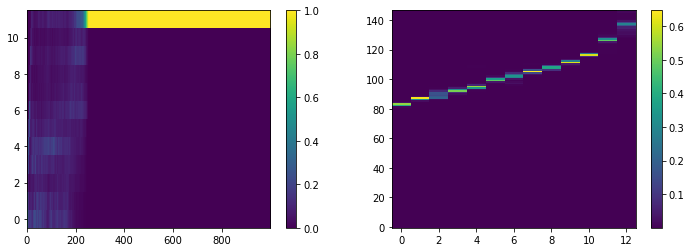

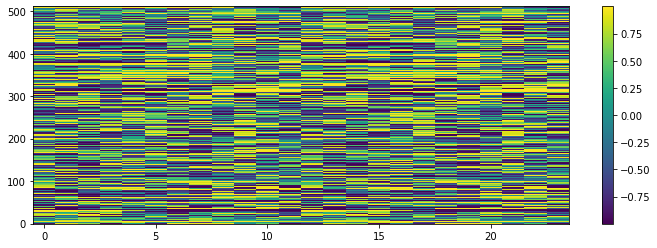

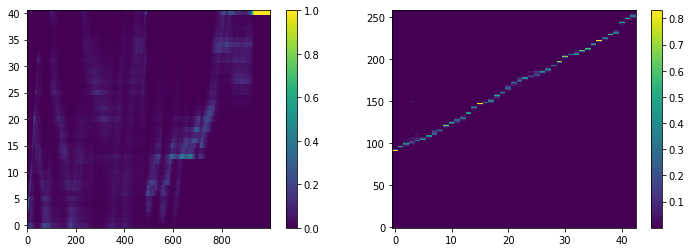

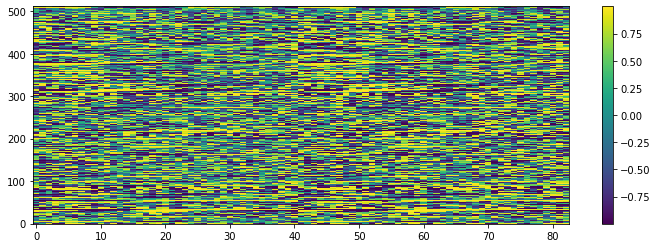

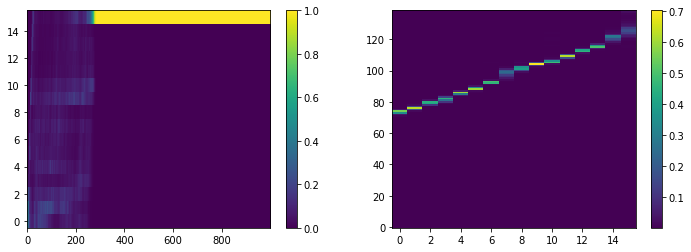

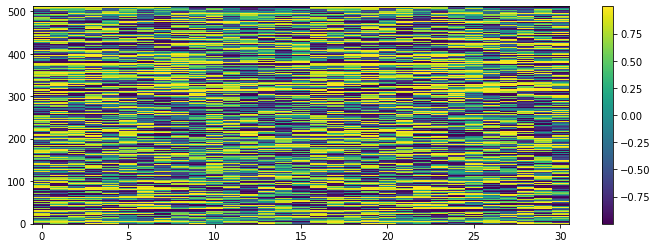

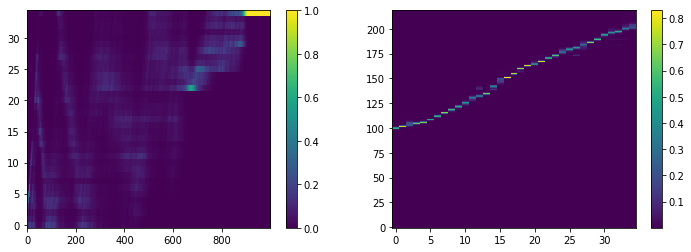

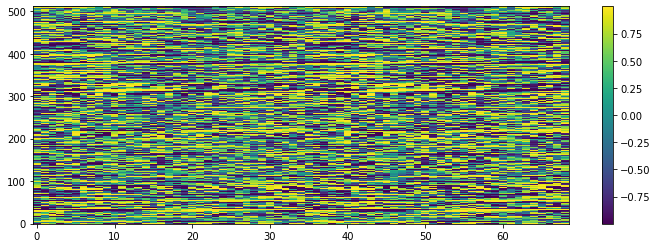

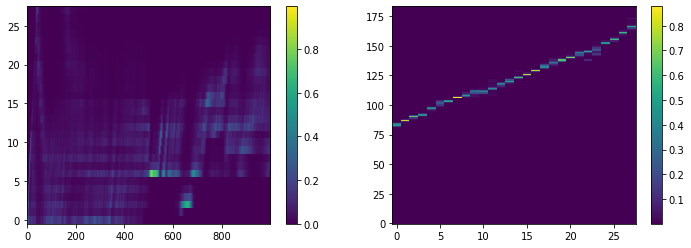

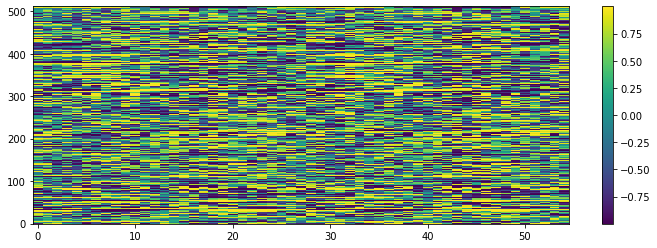

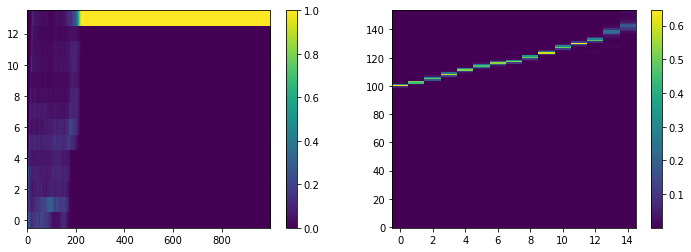

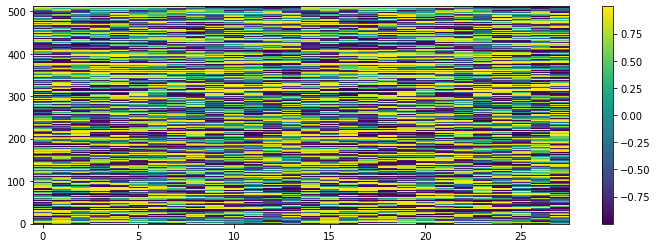

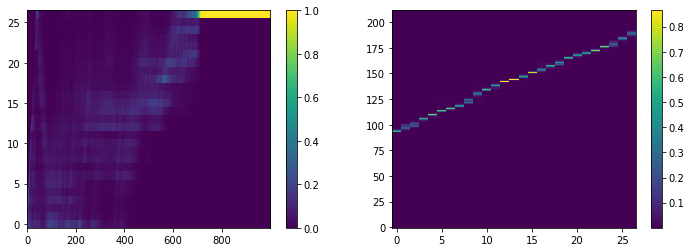

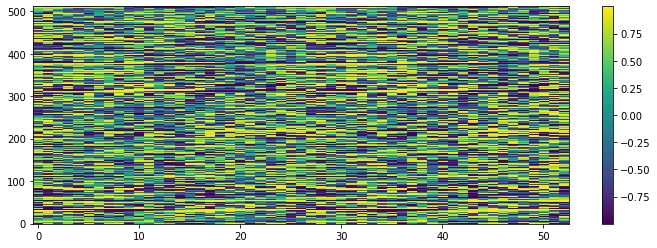

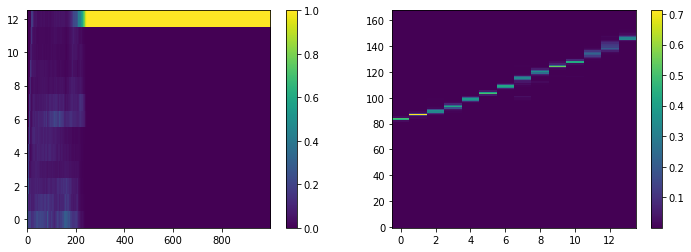

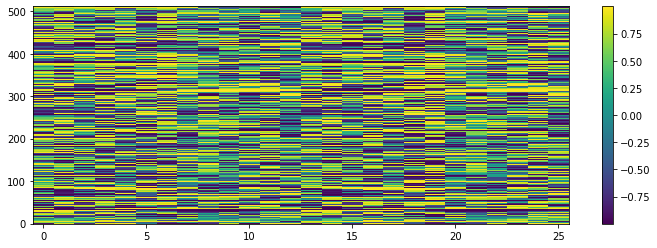

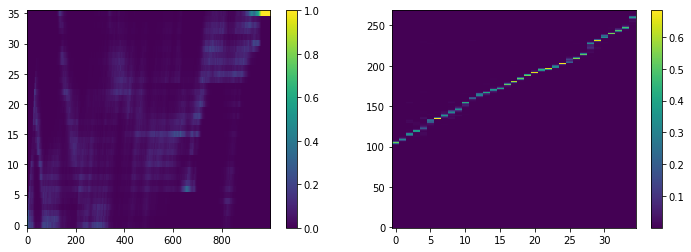

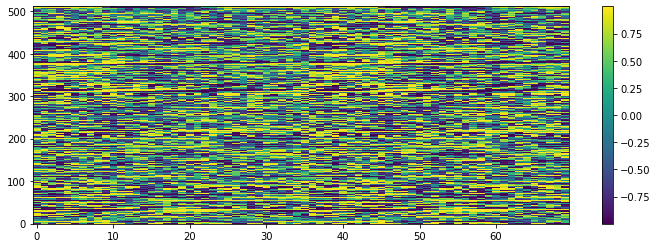

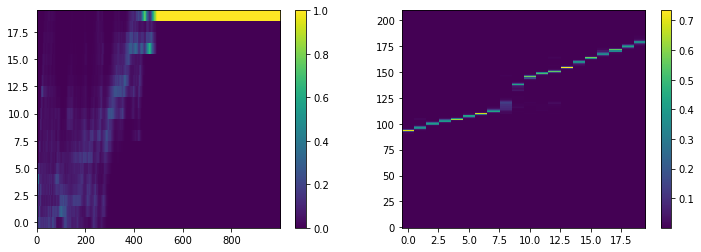

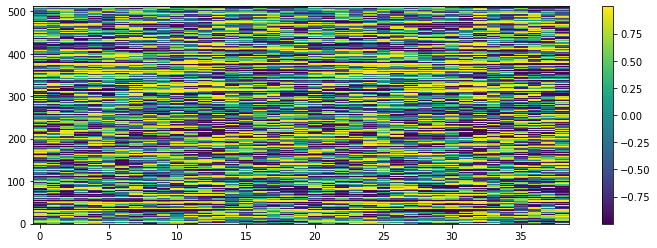

In [13]:
with torch.no_grad():
    errs = 0
    totalphs = 0
    for i, batch in enumerate(test_loader):
        if i == NUM:
            break
        sample_id = sample_list[i].split('/')[-1][9:17]
        print(('%d index %s, decoding ...'%(i,sample_id)))

        x, y = model.parse_batch(batch)
        predicted_mel, post_output, predicted_stop, alignments, \
            text_hidden, audio_seq2seq_hidden, audio_seq2seq_phids, audio_seq2seq_alignments, \
            speaker_id = model.inference(x, input_text, reference_mel, hparams.beam_width)

        post_output = post_output.data.cpu().numpy()[0]
        alignments = alignments.data.cpu().numpy()[0].T
        audio_seq2seq_alignments = audio_seq2seq_alignments.data.cpu().numpy()[0].T

        text_hidden = text_hidden.data.cpu().numpy()[0].T #-> [hidden_dim, max_text_len]
        audio_seq2seq_hidden = audio_seq2seq_hidden.data.cpu().numpy()[0].T
        audio_seq2seq_phids = audio_seq2seq_phids.data.cpu().numpy()[0] # [T + 1]
        speaker_id = speaker_id.data.cpu().numpy()[0] # scalar

        task = 'TTS' if input_text else 'VC'

        recover_wav(post_output, 
                    os.path.join(path_save, 'Wav_%s_ref_%s_%s.wav'%(sample_id, ref_sp, task)), 
                    ismel=ISMEL)
        
        post_output_path = os.path.join(path_save, 'Mel_%s_ref_%s_%s.npy'%(sample_id, ref_sp, task))
        np.save(post_output_path, post_output)
                
        plot_data([alignments, audio_seq2seq_alignments], 
            os.path.join(path_save, 'Ali_%s_ref_%s_%s.pdf'%(sample_id, ref_sp, task)))
        
        plot_data([np.hstack([text_hidden, audio_seq2seq_hidden])], 
            os.path.join(path_save, 'Hid_%s_ref_%s_%s.pdf'%(sample_id, ref_sp, task)))
         
        audio_seq2seq_phids = [id2ph[id] for id in audio_seq2seq_phids[:-1]]
        target_text = y[0].data.cpu().numpy()[0]
        target_text = [id2ph[id] for id in target_text[:]]

        print('Sounds like %s, Decoded text is '%(id2sp[speaker_id]))

        print(audio_seq2seq_phids)
        print(target_text)
       
        err = levenshteinDistance(audio_seq2seq_phids, target_text)
        print(err, len(target_text))

        errs += err
        totalphs += len(target_text)